In [1]:
import time
from collections import deque, namedtuple
import snake_env
import gymnasium
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


importing all neccesary environments 

In [2]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

In addition, we also have to initialise our hyper parameters
MEMORY_SIZE determines how large the buffer is, used to store experiences
GAMMA is a discount where the future reward have a tendency to be decreased overtime
ALPHA is the learning rate we used for the update in deep Q learning
NUM_STEPS_FOR_UPDATE determines how many steps we have to acquire before updating the q network and soft updating the target q network

import all necessary library to build ourself deep q learning 

In [3]:
env = snake_env.SnakeEnv()

We set up some display so the user can see inside the box

In [4]:
env.reset()

(array([0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.], dtype=float32),
 {'score': 0})

but first, we have to reset our environment to the initial state

In [5]:
state_size = env.observation_space.shape
num_actions = env.action_space.n
print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (11,)
Number of actions: 4


In [6]:
observation, reward, terminated, truncated, _ = env.step(action = 3)
print(observation)
print(reward)
print(terminated)

[0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.]
0
False


    ACTION:
    -UP = 0
    -RIGHT = 1
    -DOWN = 2
    -LEFT = 3
    OBSERVATION
    -danger_straight
    -danger_right
    -danger_left
    -dir_up
    -dir_right
    -dir_down
    -dir_left,
    -food_up
    -food_down
    -food_left
    -food_right


In [7]:
q_network = tf.keras.Sequential([
    tf.keras.Input(shape = state_size),
    tf.keras.layers.Dense(units = 64, activation = 'relu'),
    tf.keras.layers.Dense(units = 64, activation = 'relu'),
    tf.keras.layers.Dense(units = num_actions, activation = 'linear')
    ])
target_q_network = tf.keras.Sequential([
    tf.keras.Input(shape = state_size),
    tf.keras.layers.Dense(units = 64, activation = 'relu'),
    tf.keras.layers.Dense(units = 64, activation = 'relu'),
    tf.keras.layers.Dense(units = num_actions, activation = 'linear')
    ])

Next we will initialize 2 networks, q network and target q network, both share the same architecture. We can only just initialize 1 network only, however, for alot of reasons: such as for stable learning, avoiding oscillations, etc..
We will use 2 networks which will help our agent stable the learning

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate= ALPHA)

Initialize our Adam optimizer

In [9]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])


-Initialize our experience buffer 

-Experience replay consists of storing the agent's experiences (i.e the states, actions, and rewards the agent receives) in a memory buffer and then sampling a random mini-batch of experiences from the buffer to do the learning. The experience tuples  (𝑆𝑡,𝐴𝑡,𝑅𝑡,𝑆𝑡+1) will be added to the memory buffer at each time step as the agent interacts with the environment.

-By using experience replay we avoid problematic correlations, oscillations and instabilities. In addition, experience replay also allows the agent to potentially use the same experience in multiple weight updates, which increases data efficiency

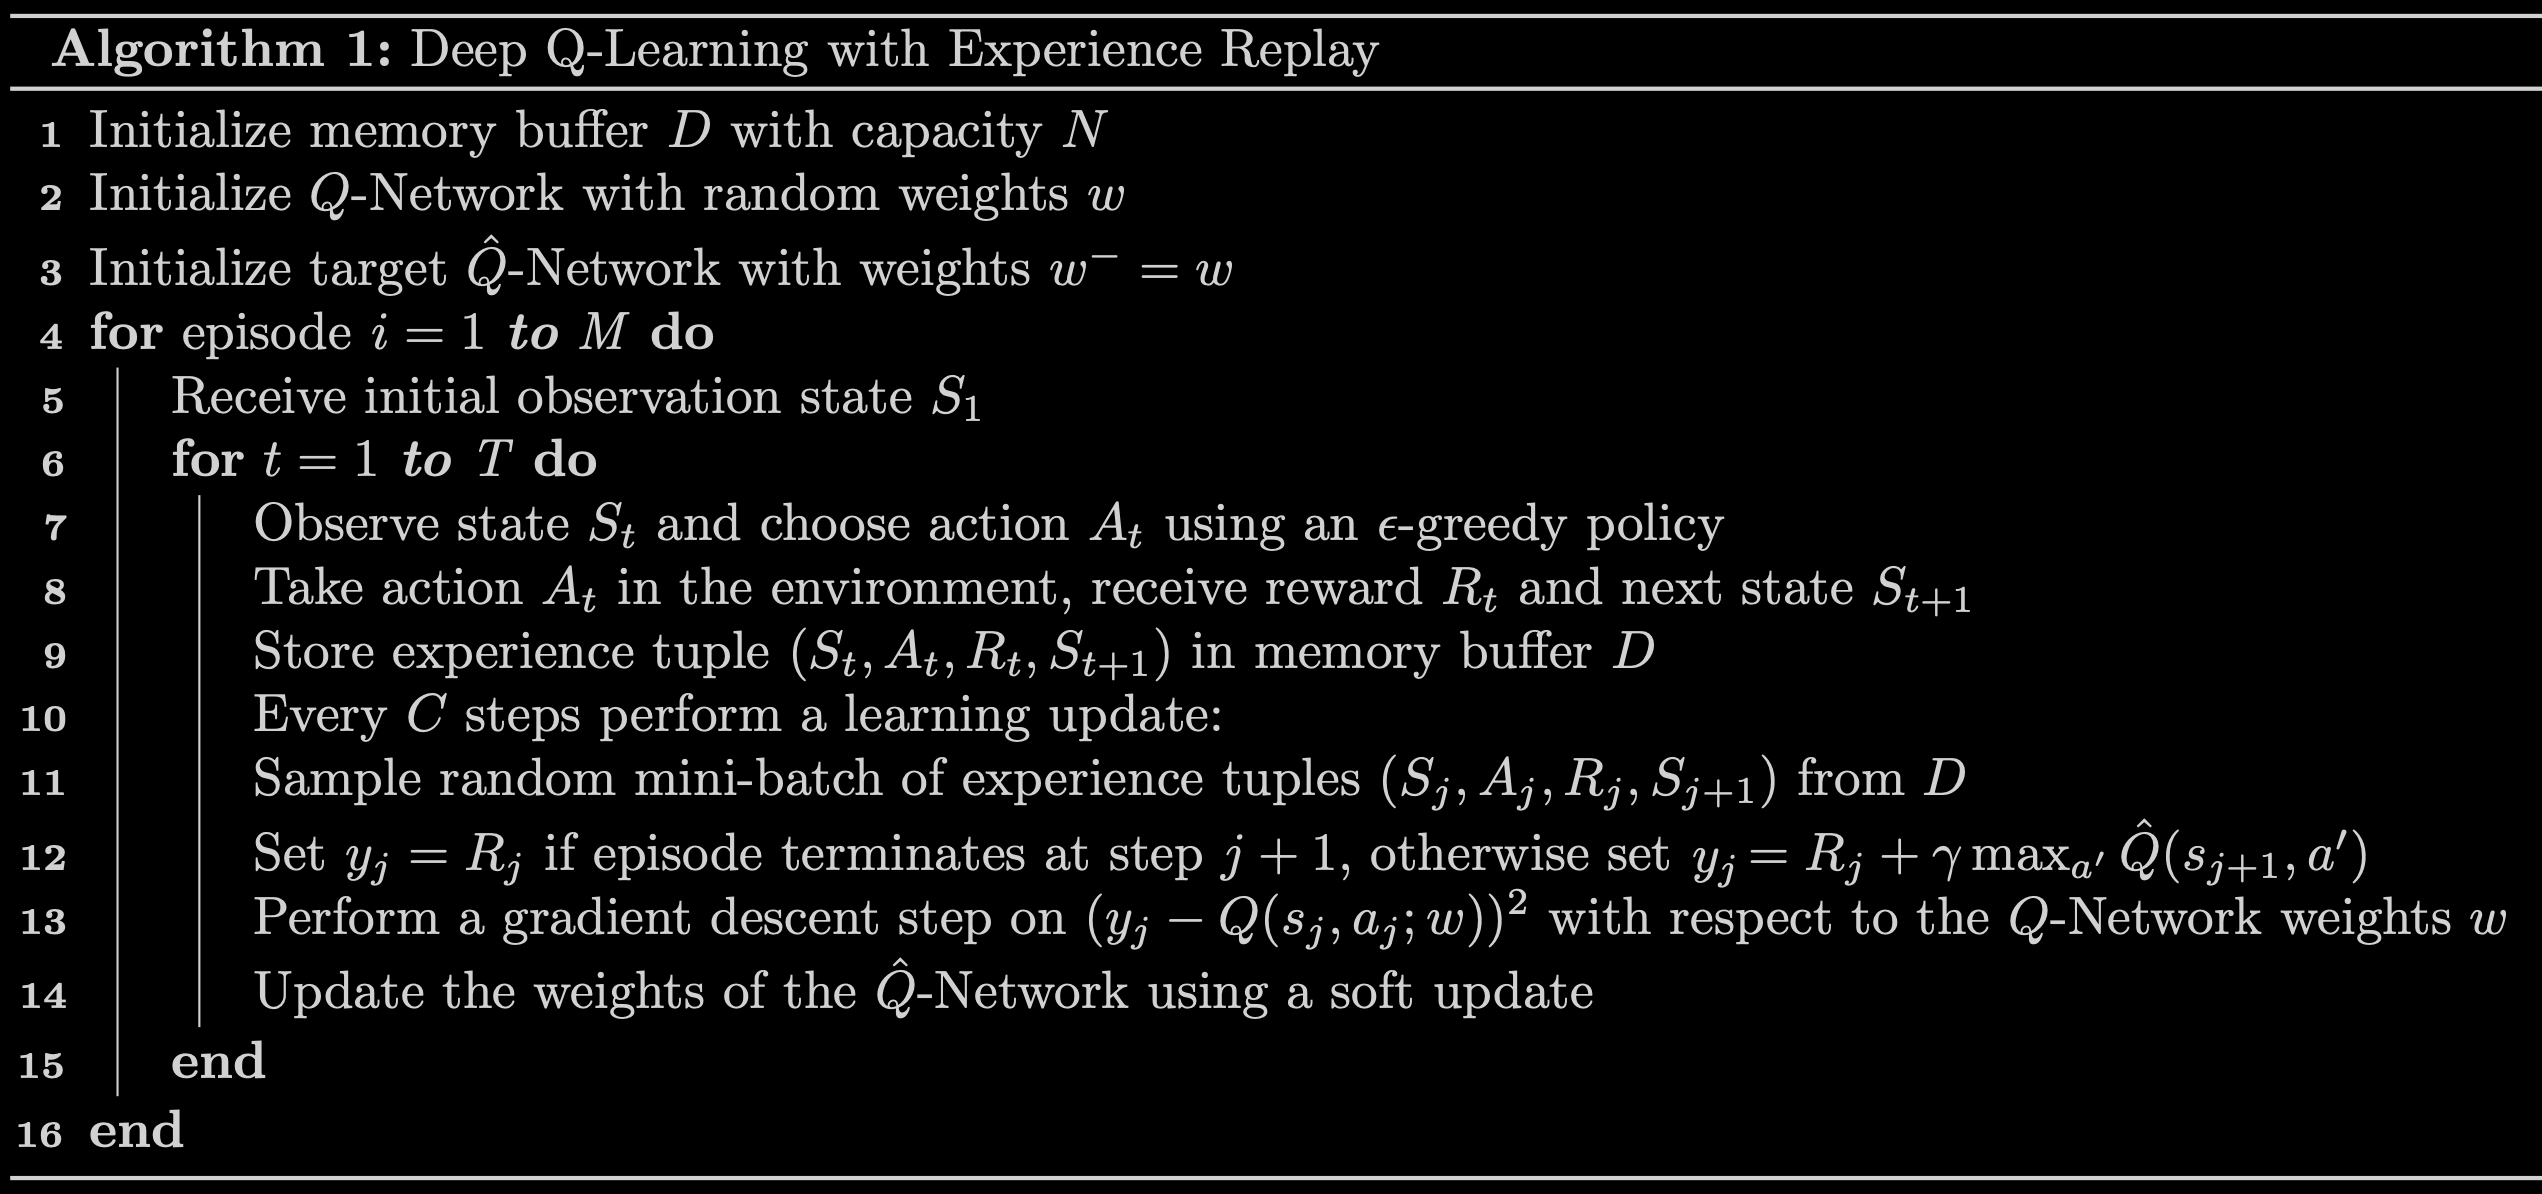


Deep Q learning algorithm

In [10]:
from tensorflow.keras.losses import MSE

In [11]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    states, actions, rewards, next_states, done_vals = experiences
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    y_targets = rewards + max_qsa*gamma*(1 - done_vals)
    ##NOTE: we store this under batch type, so the output is (batch_size,) dimension
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
    loss = MSE(y_targets, q_values)
    
    return loss

# Understanding the compute_loss Function

## What is compute_loss?
The `compute_loss` function is the **heart of Deep Q-Learning**. It calculates how far off our Q-network's predictions are from the "target" values we want them to learn. This mismatch (loss) guides the network's weight updates during training.

## The Deep Q-Learning Update Rule
In Q-Learning, we want to learn the optimal action-value function Q(s,a), which represents the expected reward from taking action `a` in state `s`.

The **Bellman equation** forms the core principle:
$$Q(s,a) = E[R + \gamma \max_{a'} Q(s',a')]$$

Where:
- **R**: immediate reward from taking action `a` in state `s`
- **γ (gamma)**: discount factor (how much we value future rewards vs immediate rewards)
- **max_{a'} Q(s',a')**: the maximum Q-value for all possible actions in the next state `s'`
- **s'**: the next state after taking action `a`

## Loss Function
We use **Mean Squared Error (MSE)** to measure the difference between:
- **y_target**: what we want the network to predict (the "ground truth")
- **q_values**: what the network actually predicts

$$\text{Loss} = \text{MSE}(y_{target}, Q_{predicted}) = \frac{1}{n}\sum_{i=1}^{n}(y_{target,i} - Q_{predicted,i})^2$$


## Step-by-Step Breakdown

### Step 1: Unpack the Experience Batch
```
states, actions, rewards, next_states, done_vals = experiences
```
- **states**: The current state(s) the agent was in | Shape: (batch_size, state_dims)
- **actions**: The action(s) taken by the agent | Shape: (batch_size,)
- **rewards**: The reward(s) received | Shape: (batch_size,)
- **next_states**: The resulting state(s) after taking the action | Shape: (batch_size, state_dims)
- **done_vals**: Whether the episode ended (1=ended, 0=continue) | Shape: (batch_size,)

### Step 2: Get Max Q-values from Next States (Using Target Network)
```
max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
```
- Pass all next_states through the **target Q-network** to get predicted Q-values for each action
- `target_q_network(next_states)` outputs shape: (batch_size, num_actions)
- `tf.reduce_max(..., axis=-1)` finds the **maximum Q-value** for each next state across all possible actions
- Result `max_qsa` shape: (batch_size,) - one max value per state

**Why target network?** Using a separate target network (with older weights) provides stability. If we used the same network, we'd be creating a moving target, causing oscillations.

### Step 3: Compute Target Q-values (The "Ground Truth")
```
y_targets = rewards + max_qsa*gamma*(1 - done_vals)
```
This implements the Bellman equation:
- Start with immediate `rewards`
- Add discounted future value: `max_qsa * gamma`
- Multiply by `(1 - done_vals)`: if episode ended, there's no future, so multiply by 0; otherwise multiply by 1
- Result: **target Q-values** that tell the network "this is what you should have predicted"

Shape: (batch_size,)

### Step 4: Get Q-values from Current States (Using Main Network)
```
q_values = q_network(states)
```
- Pass all states through the **main Q-network**
- Output shape: (batch_size, num_actions) - Q-value predictions for each state-action pair

### Step 5: Extract Only the Q-values for Actions That Were Taken
```
q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                            tf.cast(actions, tf.int32)], axis=1))
```
- `tf.range(q_values.shape[0])`: indices [0, 1, 2, ..., batch_size-1]
- `tf.cast(actions, tf.int32)`: the action indices that were actually taken
- `tf.stack(..., axis=1)`: creates pairs like [[0, action_0], [1, action_1], ...]
- `tf.gather_nd`: selects Q-values at those specific indices
- Result: only the Q-values for the **actions that were actually taken** | Shape: (batch_size,)

**Example:**
If `q_values = [[1.2, 3.5, 0.8], [2.1, 1.9, 4.2]]` (batch_size=2, num_actions=3)
And `actions = [1, 2]` (took action 1 and action 2)
Result: `[3.5, 4.2]` (the predictions for the actions taken)

### Step 6: Calculate Loss
```
loss = MSE(y_targets, q_values)
```
- Compare predicted Q-values with target Q-values using Mean Squared Error
- **Low loss** = network's predictions are close to targets (good!)
- **High loss** = network's predictions are far from targets (bad - needs updating)
- This loss value is used to backpropagate and update the network weights

## Summary
| Step | Operation | Input Shape | Output Shape |
|------|-----------|-------------|--------------|
| 1 | Unpack experiences | - | Various (batch_size, ...) |
| 2 | Max Q from target net | (batch_size, state_dims) | (batch_size,) |
| 3 | Bellman equation | - | (batch_size,) |
| 4 | Q-values from main net | (batch_size, state_dims) | (batch_size, num_actions) |
| 5 | Select action Q-values | (batch_size, num_actions) | (batch_size,) |
| 6 | Calculate MSE loss | 2 × (batch_size,) | scalar (1 value) |


## Visual Example: Tracing Through with Real Numbers

Let's trace through a concrete example to see how the function works:

**Setup:**
- batch_size = 2 (we're processing 2 experiences)
- num_actions = 4 (UP, RIGHT, DOWN, LEFT)
- gamma = 0.99

**Input Data:**
```
states = [[0,0,1,0,1,0,0,1,0,0,1],    # State 1
          [0,0,0,1,0,1,0,0,1,0,0]]    # State 2

actions = [1, 2]                        # Took RIGHT, then DOWN

rewards = [10, -1]                      # Got +10, then -1

next_states = [[0,0,0,1,1,0,0,1,1,0,0],  # State 1'
               [0,0,1,0,0,1,0,1,0,0,1]]   # State 2'

done_vals = [0, 0]                      # Both episodes continue (not done)
```

**Processing:**

**Step 2:** Target network processes next_states:
```
target_q_network(next_states) = [
    [2.5, 3.2, 1.8, 2.1],  # Q-values for actions in state 1'
    [1.9, 2.8, 3.5, 2.2]   # Q-values for actions in state 2'
]

max_qsa = [3.2, 3.5]  # Max Q-value for each next state
```

**Step 3:** Bellman equation:
```
y_targets = rewards + max_qsa * gamma * (1 - done_vals)
          = [10, -1] + [3.2, 3.5] * 0.99 * [1, 1]
          = [10, -1] + [3.168, 3.465]
          = [13.168, 2.465]
```

**Step 4:** Main network processes current states:
```
q_network(states) = [
    [1.5, 2.8, 0.9, 1.2],  # Q-values for all actions in state
    [2.1, 1.5, 3.2, 1.9]   # Q-values for all actions in state 2
]
```

**Step 5:** Extract only the Q-values we took:
```
For sample 0: action=1 (RIGHT)  → q_values[0][1] = 2.8
For sample 1: action=2 (DOWN)   → q_values[1][2] = 3.2

q_values = [2.8, 3.2]
```

**Step 6:** Calculate loss:
```
Loss = MSE([13.168, 2.465], [2.8, 3.2])
     = mean([(13.168-2.8)², (2.465-3.2)²])
     = mean([107.16, 0.54])
     = 53.85
```

The network's predictions (2.8, 3.2) are far from the targets (13.168, 2.465), so the loss is high. This will trigger backpropagation to update weights and make better predictions next time.


## Hard Update vs Soft Update

**Hard Update** (current method):
- Copies all weights from main network to target network
- Sudden change can cause instability

**Soft Update** (recommended):
- Gradually blends old and new weights using a coefficient τ (tau)
- More stable learning: `target_weight = (1 - τ) * target_weight + τ * main_weight`
- Prevents abrupt changes that can destabilize training


In [12]:
def update_target_network_soft(q_network, target_q_network, tau=0.001):
    main_weights = q_network.get_weights()
    target_weights = target_q_network.get_weights()
    
    updated_weights = [
    (1 - tau) * target_w + tau * main_w
    for target_w, main_w in zip(target_weights, main_weights)
    ]

    target_q_network.set_weights(updated_weights)

In [39]:
def agent_learn(experiences, gamma, tau = 0.001):
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    update_target_network_soft(q_network, target_q_network, tau)
    return loss

## Epsilon-Greedy Policy with get_action()

**ε-Greedy** balances **exploration** vs **exploitation**:
- **Exploitation** (probability 1-ε): Choose the action with highest Q-value (greedy)
- **Exploration** (probability ε): Choose a random action (explore)

**Why balance?**
- Pure exploitation: Agent gets stuck in local optima, never discovers better strategies
- Pure exploration: Agent learns nothing, just takes random actions
- ε-Greedy: Sweet spot - exploit learned knowledge most of the time, occasionally explore

**How it works:**
$$\text{action} = \begin{cases} 
\text{random action} & \text{if } \text{random}() < \epsilon \\
\text{argmax}(Q(s, \cdot)) & \text{otherwise}
\end{cases}$$

**Typical ε schedule:**
- Start: ε = 1.0 (100% explore)
- During training: Gradually decrease ε
- End: ε ≈ 0.01 (99% exploit, 1% explore)

**Example with 4 actions and ε = 0.1:**
- 90% of time: Pick action with highest Q-value
- 10% of time: Pick a random action (UP, RIGHT, DOWN, or LEFT equally)


In [14]:
def get_action(q_values, epsilon):

    num_actions = q_values.shape[-1]
    
    # Generate random number between 0 and 1
    rand = np.random.random()
    
    if rand < epsilon:
        # EXPLORE: Choose a random action
        action = np.random.randint(0, num_actions)
    else:
        # EXPLOIT: Choose action with maximum Q-value
        # Convert tensor to numpy array and squeeze to get 1D array
        q_values_np = q_values.numpy().squeeze()
        action = np.argmax(q_values_np)
    
    return action

In [15]:
def check_update_conditions(t, num_steps_for_update, memory_buffer, min_buffer_size=1000):
    # Do not update until we have enough data
    if len(memory_buffer) < min_buffer_size:
        return False

    # Update only every "num_steps_for_update" steps
    if t % num_steps_for_update != 0:
        return False

    return True

    

In [16]:
def get_experiences(memory_buffer, batch_size = 1000):
    # Randomly sample batch indices
    idx = np.random.choice(len(memory_buffer), size=batch_size, replace=False)
    batch = [memory_buffer[i] for i in idx]

    # Convert to arrays with correct dtypes for TensorFlow
    states      = np.array([b.state      for b in batch], dtype=np.float32)
    actions     = np.array([b.action     for b in batch], dtype=np.int32)
    rewards     = np.array([b.reward     for b in batch], dtype=np.float32)
    next_states = np.array([b.next_state for b in batch], dtype=np.float32)
    dones       = np.array([b.done       for b in batch], dtype=np.float32)

    # This matches what compute_loss() expects
    return states, actions, rewards, next_states, dones

In [17]:
def get_new_eps(epsilon, min_eps=0.01, decay=0.995):
    # Decay epsilon
    new_epsilon = max(min_eps, decay * epsilon)
    return new_epsilon

we create a function to plot our loss history and reward history !! 

In [46]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []
total_loss_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    reset_res = env.reset()
    # Gymnasium env.reset() often returns (obs, info). Ensure we extract the observation.
    if isinstance(reset_res, (tuple, list)):
        state = reset_res[0]
    else:
        state = reset_res

    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        # Make sure `state` is a numpy array / properly shaped observation
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network (4,) -> (1,4)
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        step_res = env.step(action)
        # Handle both Gym (4-tuple) and Gymnasium (5-tuple) return signatures
        if isinstance(step_res, tuple) and len(step_res) == 5:
            next_state, reward, terminated, truncated, _info = step_res
            done = bool(terminated or truncated)
        elif isinstance(step_res, tuple) and len(step_res) == 4:
            next_state, reward, done, _info = step_res
            done = bool(done)
        else:
            # Fallback: try to assume step_res is (next_state, reward, done, info)-like
            try:
                next_state, reward, done, _info = step_res
                done = bool(done)
            except Exception:
                # If we cannot unpack, set next_state to step_res and assume not done
                next_state = step_res
                reward = 0
                done = False
        
        # If next_state is (obs, info) style, extract obs
        if isinstance(next_state, (tuple, list)):
            next_state = next_state[0]
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            loss = agent_learn(experiences, GAMMA)
            total_loss_history.append(loss)
                


        # Move to the next state
        state = next_state.copy() if hasattr(next_state, 'copy') else next_state
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = get_new_eps(epsilon)
    

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 100 points in the last 100 episodes.
    if av_latest_points >= 100.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('snake_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -0.50
Episode 200 | Total point average of the last 100 episodes: 18.20
Episode 300 | Total point average of the last 100 episodes: 39.30
Episode 400 | Total point average of the last 100 episodes: 56.10
Episode 500 | Total point average of the last 100 episodes: 99.80
Episode 501 | Total point average of the last 100 episodes: 99.60

Episode 502 | Total point average of the last 100 episodes: 101.70

Environment solved in 502 episodes!

Total Runtime: 1228.02 s (20.47 min)


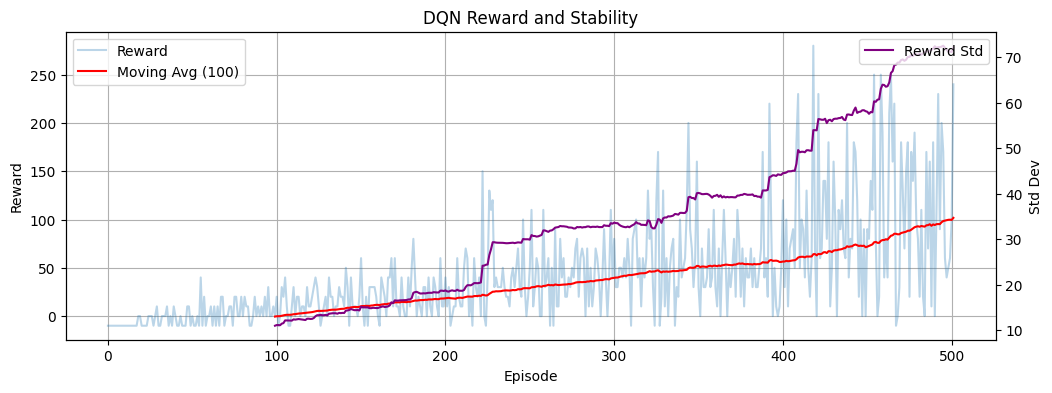

In [54]:
def plot_reward_and_variance(rewards, window=100):


    rewards = np.array(rewards)
    episodes = np.arange(len(rewards))

    fig, ax1 = plt.subplots(figsize=(12, 4))

    # Reward
    ax1.plot(episodes, rewards, alpha=0.3, label='Reward')
    ma = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax1.plot(episodes[window-1:], ma, color='red',
             label=f'Moving Avg ({window})')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Variance
    ax2 = ax1.twinx()
    moving_std = [
        rewards[i:i+window].std()
        for i in range(len(rewards) - window + 1)
    ]
    ax2.plot(episodes[window-1:], moving_std, color='purple',
             label='Reward Std')
    ax2.set_ylabel('Std Dev')
    ax2.legend(loc='upper right')

    plt.title('DQN Reward and Stability')
    plt.show()
plot_reward_and_variance(total_point_history, window=100)

create a function to plot reward and reward variance 

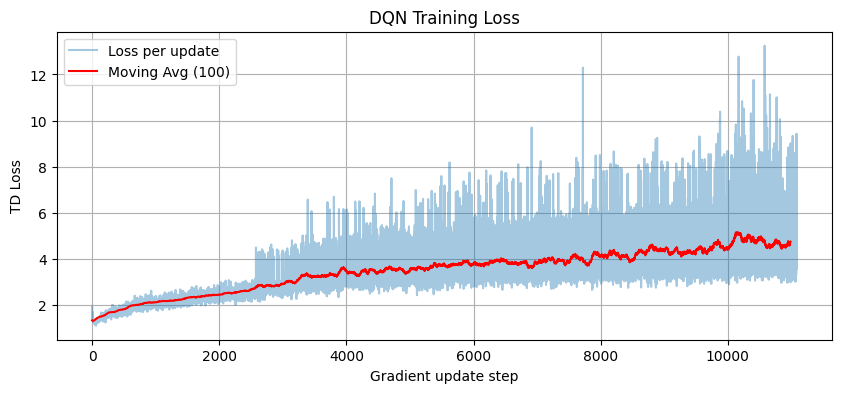

In [50]:
def plot_dqn_loss(losses, window=100):
    import numpy as np
    import matplotlib.pyplot as plt

    losses = np.array(losses)

    plt.figure(figsize=(10, 4))
    plt.plot(losses, alpha=0.4, label='Loss per update')

    if len(losses) >= window:
        ma = np.convolve(losses, np.ones(window)/window, mode='valid')
        plt.plot(ma, color='red', label=f'Moving Avg ({window})')

    plt.xlabel('Gradient update step')
    plt.ylabel('TD Loss')
    plt.title('DQN Training Loss')
    plt.grid(True)
    plt.legend()
    plt.show()
plot_dqn_loss(total_loss_history, window=100)

create a function to plot our loss function 

In [55]:
# Load the trained model
trained_model = tf.keras.models.load_model("snake_model.h5")
print("✓ Model loaded successfully!")
print("\nModel Architecture:")
trained_model.summary()

✓ Model loaded successfully!

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,188 (20.27 KB)

 Trainable params: 5,188 (20.27 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
def run_episode(model, env, num_steps=1000, epsilon=0.0, render=False):
    
    reset_res = env.reset()
    if isinstance(reset_res, (tuple, list)):
        state = reset_res[0]
    else:
        state = reset_res
    
    total_reward = 0
    step_count = 0
    states_visited = [state.copy()]
    actions_taken = []
    
    for t in range(num_steps):
        # Get Q-values from trained model
        state_input = np.expand_dims(state, axis=0)
        q_values = model(state_input)
        
        # Choose action using epsilon-greedy (mostly exploitation)
        rand = np.random.random()
        if rand < epsilon:
            action = np.random.randint(0, num_actions)
        else:
            action = np.argmax(q_values.numpy().squeeze())
        
        actions_taken.append(action)
        
        # Take step in environment
        step_res = env.step(action)
        if isinstance(step_res, tuple) and len(step_res) == 5:
            next_state, reward, terminated, truncated, _info = step_res
            done = bool(terminated or truncated)
        elif isinstance(step_res, tuple) and len(step_res) == 4:
            next_state, reward, done, _info = step_res
            done = bool(done)
        else:
            next_state, reward, done = step_res[0], step_res[1], step_res[2]
        
        if isinstance(next_state, (tuple, list)):
            next_state = next_state[0]
        
        total_reward += reward
        step_count += 1
        states_visited.append(next_state.copy())
        state = next_state.copy() if hasattr(next_state, 'copy') else next_state
        
        if done:
            break
    
    return total_reward, step_count, states_visited, actions_taken

print("✓ run_episode() function defined!")

✓ run_episode() function defined!


In [57]:
# Test the trained model on 10 episodes
print("Testing trained model...\n")

test_rewards = []
test_steps = []

for episode in range(10):
    reward, steps, _, _ = run_episode(trained_model, env, num_steps=1000, epsilon=0.0, render=True)
    test_rewards.append(reward)
    test_steps.append(steps)
    print(f"Episode {episode+1}: Reward = {reward:.1f}, Steps = {steps}")

print(f"\nAverage Reward: {np.mean(test_rewards):.1f}")
print(f"Average Steps: {np.mean(test_steps):.0f}")

Testing trained model...

Episode 1: Reward = 250.0, Steps = 314
Episode 2: Reward = 250.0, Steps = 325
Episode 3: Reward = 180.0, Steps = 237
Episode 4: Reward = 360.0, Steps = 565
Episode 5: Reward = 180.0, Steps = 205
Episode 6: Reward = 130.0, Steps = 165
Episode 7: Reward = 160.0, Steps = 231
Episode 8: Reward = 290.0, Steps = 375
Episode 9: Reward = 480.0, Steps = 652
Episode 10: Reward = 210.0, Steps = 254

Average Reward: 249.0
Average Steps: 332


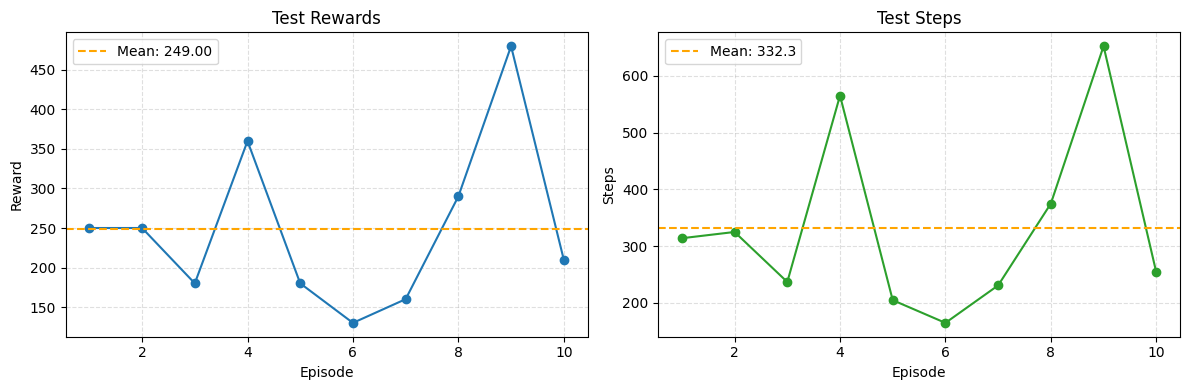

Episodes: 10 | Average reward: 249.00 | Average steps: 332.3


In [58]:
# Simple plots for test_rewards and test_steps
# Shows rewards and steps for each test episode with mean lines
import matplotlib.pyplot as plt
import numpy as np

try:
    rewards = np.array(test_rewards)
    steps = np.array(test_steps)
except NameError:
    print("Variables 'test_rewards' and 'test_steps' not found. Please run the test cell that evaluates the model first.")
else:
    if rewards.size == 0:
        print("No test episodes found in 'test_rewards'.")
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Rewards
        ax = axes[0]
        ax.plot(np.arange(1, len(rewards) + 1), rewards, marker='o', color='tab:blue')
        ax.set_title('Test Rewards')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Reward')
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.axhline(rewards.mean(), color='orange', linestyle='--', label=f'Mean: {rewards.mean():.2f}')
        ax.legend()

        # Steps
        ax2 = axes[1]
        ax2.plot(np.arange(1, len(steps) + 1), steps, marker='o', color='tab:green')
        ax2.set_title('Test Steps')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Steps')
        ax2.grid(True, linestyle='--', alpha=0.4)
        ax2.axhline(steps.mean(), color='orange', linestyle='--', label=f'Mean: {steps.mean():.1f}')
        ax2.legend()

        plt.tight_layout()
        plt.show()

        # Print quick summary
        print(f"Episodes: {len(rewards)} | Average reward: {rewards.mean():.2f} | Average steps: {steps.mean():.1f}")

In [59]:
def play_trained_model(model, episodes=5, max_steps=1000, render=False):


    env = snake_env.SnakeEnv(render_mode="human")
    scores = []

    for ep in range(episodes):
        reset_res = env.reset()
        obs = reset_res[0] if isinstance(reset_res, (tuple, list)) else reset_res

        total_score = 0
        step_count = 0
        done = False
        truncated = False

        while not done and not truncated and step_count < max_steps:
            # Prepare batched input for Keras
            obs_input = np.expand_dims(obs, axis=0).astype(np.float32)

            # Predict Q-values and pick greedy action
            q_values = model.predict(obs_input, verbose=0)[0]
            action = int(np.argmax(q_values))

            # Step environment and handle different return signatures
            step_res = env.step(action)
            if isinstance(step_res, tuple) and len(step_res) == 5:
                next_obs, reward, terminated, truncated, info = step_res
                done = bool(terminated or truncated)
            elif isinstance(step_res, tuple) and len(step_res) == 4:
                next_obs, reward, done, info = step_res
                truncated = False
                done = bool(done)
            else:
                try:
                    next_obs, reward, done, info = step_res
                    truncated = False
                    done = bool(done)
                except Exception:
                    # Unknown format — best-effort fallback
                    next_obs = step_res[0] if isinstance(step_res, (tuple, list)) and len(step_res) > 0 else step_res
                    reward = step_res[1] if isinstance(step_res, (tuple, list)) and len(step_res) > 1 else 0
                    done = False
                    truncated = False
                    info = {}

            # If next_obs is (obs, info) style, extract observation
            if isinstance(next_obs, (tuple, list)):
                next_obs = next_obs[0]

            total_score += reward
            step_count += 1
            obs = next_obs

            if render:
                try:
                    env.render()
                except Exception:
                    pass

        scores.append(total_score)
        print(f"Episode {ep+1}: Score = {total_score:.1f}, Steps = {step_count}")

    try:
        env.close()
    except Exception:
        pass

    print(f"Finished {episodes} episodes. Average score: {np.mean(scores):.2f}")
    return scores

In [60]:
play_trained_model(model=trained_model, episodes=5)

Episode 1: Score = 140.0, Steps = 185
Episode 2: Score = 190.0, Steps = 328
Episode 3: Score = 140.0, Steps = 206
Episode 4: Score = 370.0, Steps = 486
Episode 5: Score = 280.0, Steps = 340
Finished 5 episodes. Average score: 224.00


[140, 190, 140, 370, 280]

right now, we want to test other environments to see how well DQN performs on other environments

In [61]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

In [62]:
import gymnasium 

env2 = gymnasium.make('CartPole-v1')
obs, info = env2.reset()


In [63]:
state_size2 = env2.observation_space.shape
num_actions2 = env2.action_space.n
print('State Shape:', state_size2)
print('Number of actions:', num_actions2)

State Shape: (4,)
Number of actions: 2


In [64]:
q_network = tf.keras.Sequential([
    tf.keras.Input(shape = state_size2),
    tf.keras.layers.Dense(units = 64, activation = 'relu'),
    tf.keras.layers.Dense(units = 64, activation = 'relu'),
    tf.keras.layers.Dense(units = num_actions2, activation = 'linear')
    ])
target_q_network = tf.keras.Sequential([
    tf.keras.Input(shape = state_size2),
    tf.keras.layers.Dense(units = 64, activation = 'relu'),
    tf.keras.layers.Dense(units = 64, activation = 'relu'),
    tf.keras.layers.Dense(units = num_actions2, activation = 'linear')
    ])

In [65]:
optimizer = tf.keras.optimizers.Adam(learning_rate= ALPHA)

In [66]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [67]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []
total_loss_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    reset_res = env2.reset()
    # Gymnasium env.reset() often returns (obs, info). Ensure we extract the observation.
    if isinstance(reset_res, (tuple, list)):
        state = reset_res[0]
    else:
        state = reset_res

    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        # Make sure `state` is a numpy array / properly shaped observation
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network (4,) -> (1,4)
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        step_res = env2.step(action)
        # Handle both Gym (4-tuple) and Gymnasium (5-tuple) return signatures
        if isinstance(step_res, tuple) and len(step_res) == 5:
            next_state, reward, terminated, truncated, _info = step_res
            done = bool(terminated or truncated)
        elif isinstance(step_res, tuple) and len(step_res) == 4:
            next_state, reward, done, _info = step_res
            done = bool(done)
        else:
            # Fallback: try to assume step_res is (next_state, reward, done, info)-like
            try:
                next_state, reward, done, _info = step_res
                done = bool(done)
            except Exception:
                # If we cannot unpack, set next_state to step_res and assume not done
                next_state = step_res
                reward = 0
                done = False
        
        # If next_state is (obs, info) style, extract obs
        if isinstance(next_state, (tuple, list)):
            next_state = next_state[0]
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            loss = agent_learn(experiences, GAMMA)
            total_loss_history.append(loss)
        
        # Move to the next state
        state = next_state.copy() if hasattr(next_state, 'copy') else next_state
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 100 points in the last 100 episodes.
    if av_latest_points >= 100.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('cart_pole_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: 19.03
Episode 200 | Total point average of the last 100 episodes: 12.33
Episode 300 | Total point average of the last 100 episodes: 15.15
Episode 400 | Total point average of the last 100 episodes: 20.37
Episode 500 | Total point average of the last 100 episodes: 26.12
Episode 586 | Total point average of the last 100 episodes: 98.79

Episode 587 | Total point average of the last 100 episodes: 103.21

Environment solved in 587 episodes!

Total Runtime: 782.88 s (13.05 min)


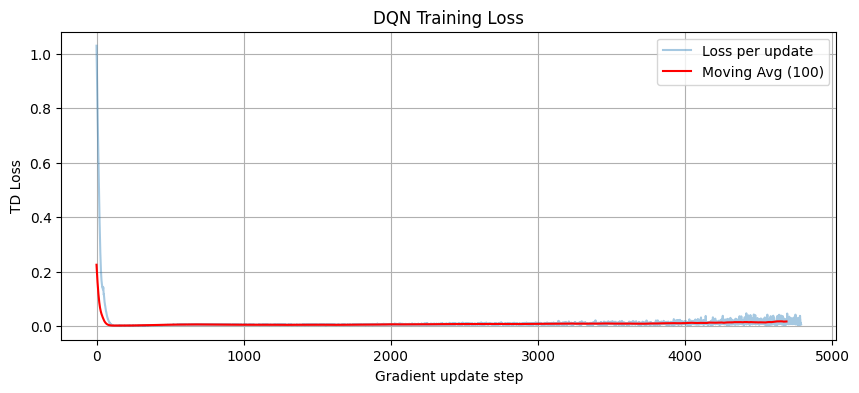

In [68]:
plot_dqn_loss(total_loss_history, window=100)

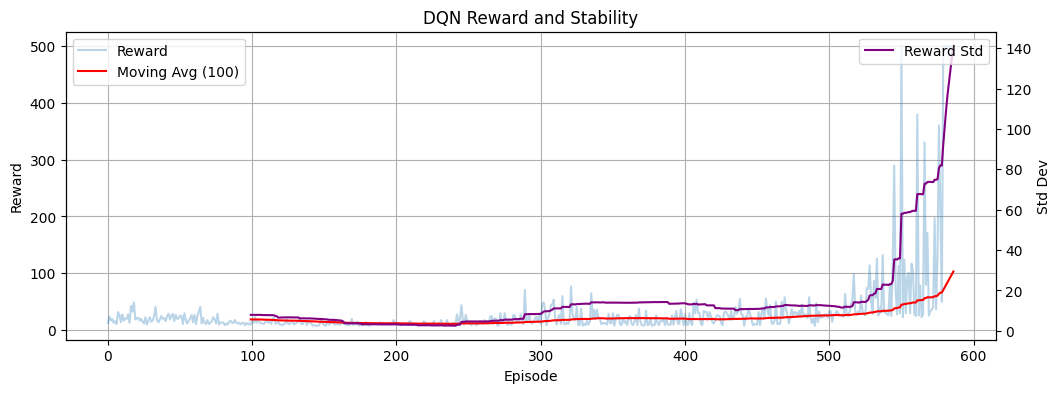

In [69]:
plot_reward_and_variance(total_point_history, window=100)

In [70]:
trained_model = tf.keras.models.load_model("cart_pole_model.h5")
print("✓ Model loaded successfully!")
print("\nModel Architecture:")
trained_model.summary()

✓ Model loaded successfully!

Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,610 (18.01 KB)

 Trainable params: 4,610 (18.01 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
print("Testing trained model...\n")

test_rewards = []
test_steps = []

for episode in range(10):
    reward, steps, _, _ = run_episode(trained_model, env2, num_steps=1000, epsilon=0.0, render=True)
    test_rewards.append(reward)
    test_steps.append(steps)
    print(f"Episode {episode+1}: Reward = {reward:.1f}, Steps = {steps}")

print(f"\nAverage Reward: {np.mean(test_rewards):.1f}")
print(f"Average Steps: {np.mean(test_steps):.0f}")

Testing trained model...

Episode 1: Reward = 287.0, Steps = 287
Episode 2: Reward = 185.0, Steps = 185
Episode 3: Reward = 196.0, Steps = 196
Episode 4: Reward = 224.0, Steps = 224
Episode 5: Reward = 500.0, Steps = 500
Episode 6: Reward = 500.0, Steps = 500
Episode 7: Reward = 319.0, Steps = 319
Episode 8: Reward = 500.0, Steps = 500
Episode 9: Reward = 235.0, Steps = 235
Episode 10: Reward = 195.0, Steps = 195

Average Reward: 314.1
Average Steps: 314


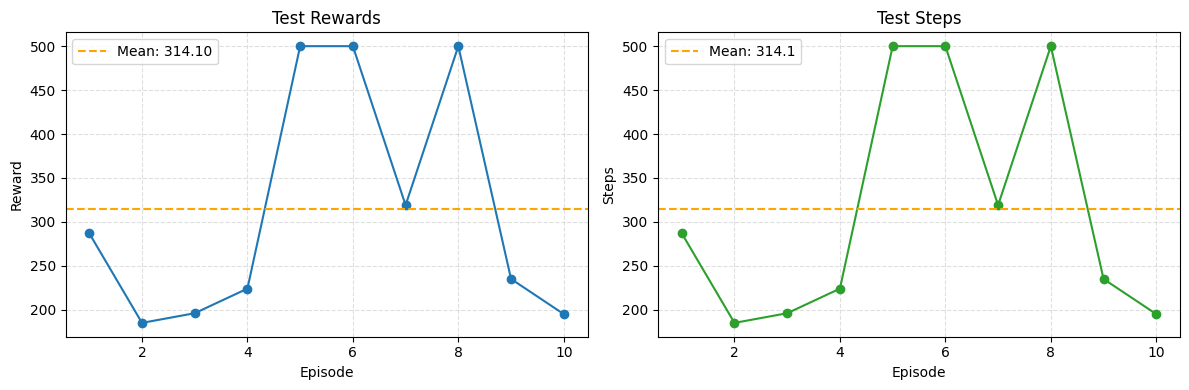

Episodes: 10 | Average reward: 314.10 | Average steps: 314.1


In [72]:
# Simple plots for test_rewards and test_steps
# Shows rewards and steps for each test episode with mean lines
import matplotlib.pyplot as plt
import numpy as np

try:
    rewards = np.array(test_rewards)
    steps = np.array(test_steps)
except NameError:
    print("Variables 'test_rewards' and 'test_steps' not found. Please run the test cell that evaluates the model first.")
else:
    if rewards.size == 0:
        print("No test episodes found in 'test_rewards'.")
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Rewards
        ax = axes[0]
        ax.plot(np.arange(1, len(rewards) + 1), rewards, marker='o', color='tab:blue')
        ax.set_title('Test Rewards')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Reward')
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.axhline(rewards.mean(), color='orange', linestyle='--', label=f'Mean: {rewards.mean():.2f}')
        ax.legend()

        # Steps
        ax2 = axes[1]
        ax2.plot(np.arange(1, len(steps) + 1), steps, marker='o', color='tab:green')
        ax2.set_title('Test Steps')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Steps')
        ax2.grid(True, linestyle='--', alpha=0.4)
        ax2.axhline(steps.mean(), color='orange', linestyle='--', label=f'Mean: {steps.mean():.1f}')
        ax2.legend()

        plt.tight_layout()
        plt.show()

        # Print quick summary
        print(f"Episodes: {len(rewards)} | Average reward: {rewards.mean():.2f} | Average steps: {steps.mean():.1f}")

In [74]:
def play_trained_model(model, episodes=5, max_steps=1000, render=False):

    env = gymnasium.make('CartPole-v1', render_mode="human")
    scores = []

    for ep in range(episodes):
        reset_res = env.reset()
        obs = reset_res[0] if isinstance(reset_res, (tuple, list)) else reset_res

        total_score = 0
        step_count = 0
        done = False
        truncated = False

        while not done and not truncated and step_count < max_steps:
            # Prepare batched input for Keras
            obs_input = np.expand_dims(obs, axis=0).astype(np.float32)

            # Predict Q-values and pick greedy action
            q_values = model.predict(obs_input, verbose=0)[0]
            action = int(np.argmax(q_values))

            # Step environment and handle different return signatures
            step_res = env.step(action)
            if isinstance(step_res, tuple) and len(step_res) == 5:
                next_obs, reward, terminated, truncated, info = step_res
                done = bool(terminated or truncated)
            elif isinstance(step_res, tuple) and len(step_res) == 4:
                next_obs, reward, done, info = step_res
                truncated = False
                done = bool(done)
            else:
                try:
                    next_obs, reward, done, info = step_res
                    truncated = False
                    done = bool(done)
                except Exception:
                    # Unknown format — best-effort fallback
                    next_obs = step_res[0] if isinstance(step_res, (tuple, list)) and len(step_res) > 0 else step_res
                    reward = step_res[1] if isinstance(step_res, (tuple, list)) and len(step_res) > 1 else 0
                    done = False
                    truncated = False
                    info = {}

            # If next_obs is (obs, info) style, extract observation
            if isinstance(next_obs, (tuple, list)):
                next_obs = next_obs[0]

            total_score += reward
            step_count += 1
            obs = next_obs

            if render:
                try:
                    env.render()
                except Exception:
                    pass

        scores.append(total_score)
        print(f"Episode {ep+1}: Score = {total_score:.1f}, Steps = {step_count}")

    try:
        env.close()
    except Exception:
        pass

    print(f"Finished {episodes} episodes. Average score: {np.mean(scores):.2f}")
    return scores

In [75]:
play_trained_model(model=trained_model, episodes=5)

Episode 1: Score = 397.0, Steps = 397
Episode 2: Score = 363.0, Steps = 363
Episode 3: Score = 500.0, Steps = 500
Episode 4: Score = 191.0, Steps = 191
Episode 5: Score = 384.0, Steps = 384
Finished 5 episodes. Average score: 367.00


[397.0, 363.0, 500.0, 191.0, 384.0]